In [1]:
%matplotlib inline
import warnings
import itertools
from datetime import datetime
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from pylab import rcParams

In [3]:
#Loading Data
act = pd.read_csv("activity.csv")

In [4]:
act.DATE = pd.to_datetime(np.array(act.DATE).astype(str)).values

In [5]:
act = act.groupby('DATE').ACTIVITY.count().reset_index()
act = act.set_index('DATE')

In [6]:
act.head()

,ACTIVITY
DATE,
2015-04-03,1029
2015-04-04,3347
2015-04-05,3350
2015-04-06,5125
2015-04-07,6158


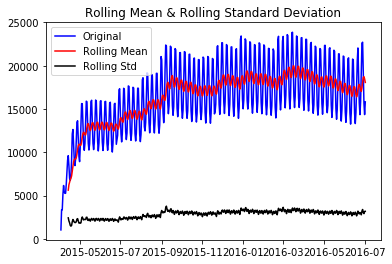

In [7]:
rolling_mean = act.rolling(window = 12).mean()
rolling_std = act.rolling(window = 12).std()
plt.plot(act, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [8]:
result = adfuller(act['ACTIVITY'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.869385588487063
p-value: 0.049025617209975524
Critical Values:
	1%: -3.445299682487321
	5%: -2.8681312035123967
	10%: -2.570280872933884


In [9]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['ACTIVITY'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

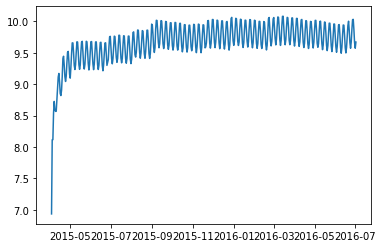

In [10]:
df_log = np.log(act)
plt.plot(df_log)

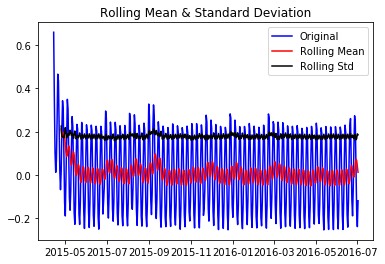

ADF Statistic: -6.170527609237263
p-value: 6.822805136631259e-08
Critical Values:
	1%: -3.445757604526768
	5%: -2.8683325885102855
	10%: -2.5703882165206853


In [11]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

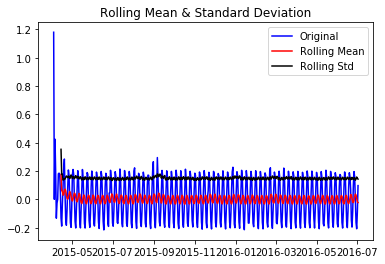

ADF Statistic: -6.189699600243946
p-value: 6.165549281249441e-08
Critical Values:
	1%: -3.445368352170937
	5%: -2.8681614049724002
	10%: -2.570296970872167


In [12]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


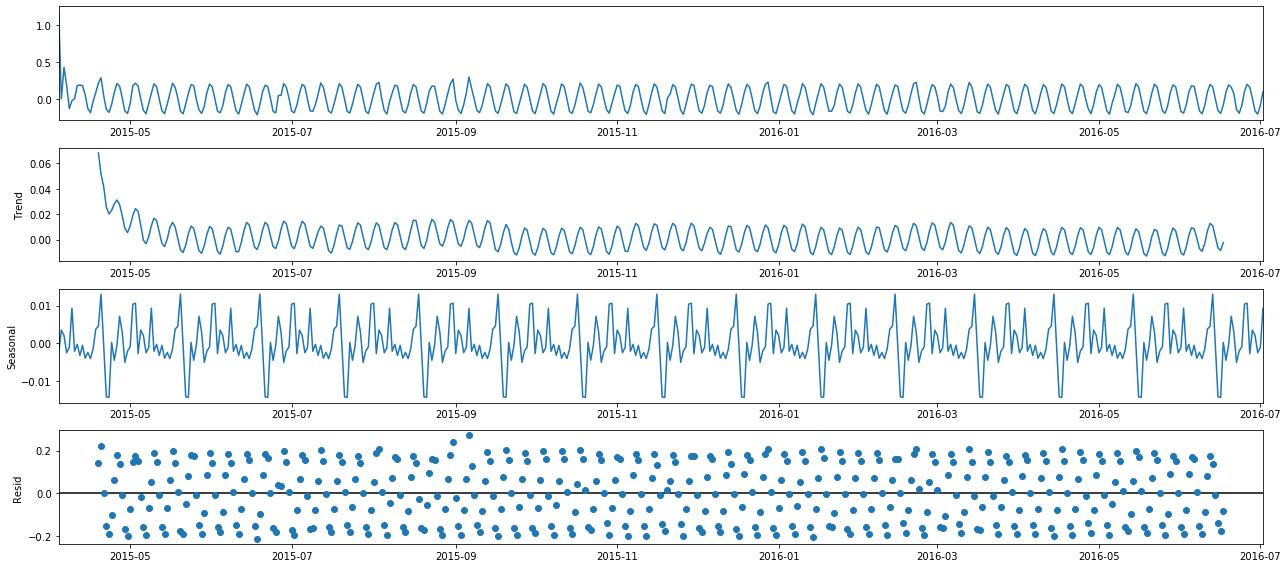

In [13]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_log_shift, model='additive', freq = 30)
fig = decomposition.plot()
plt.show()

/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


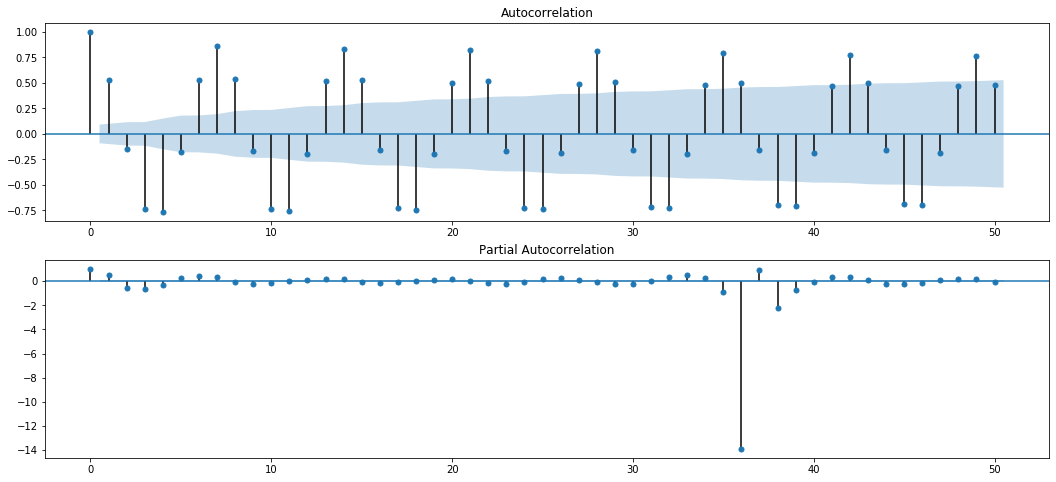

In [14]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(df_log_shift, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_log_shift, lags=50, ax=ax[1])
plt.show()

/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.704451
         Iterations: 9
         Function evaluations: 1065


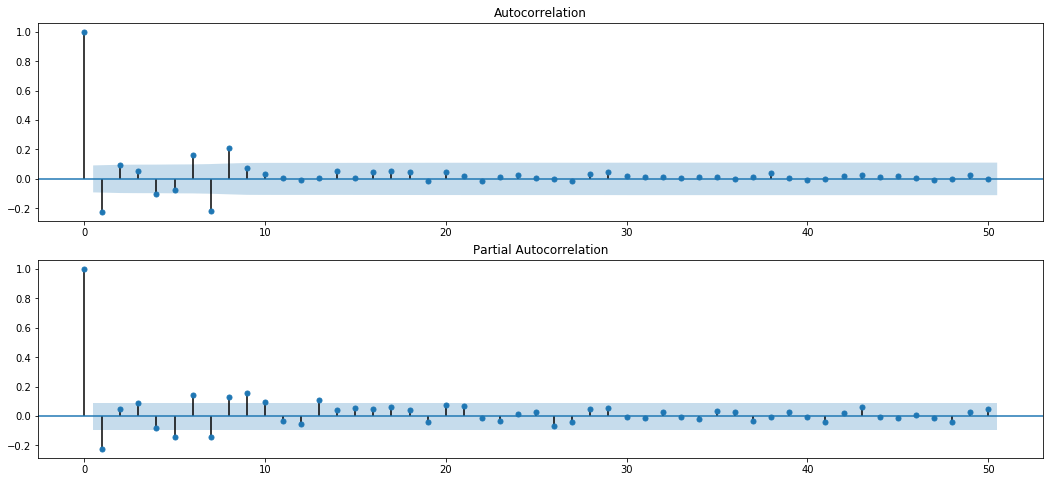

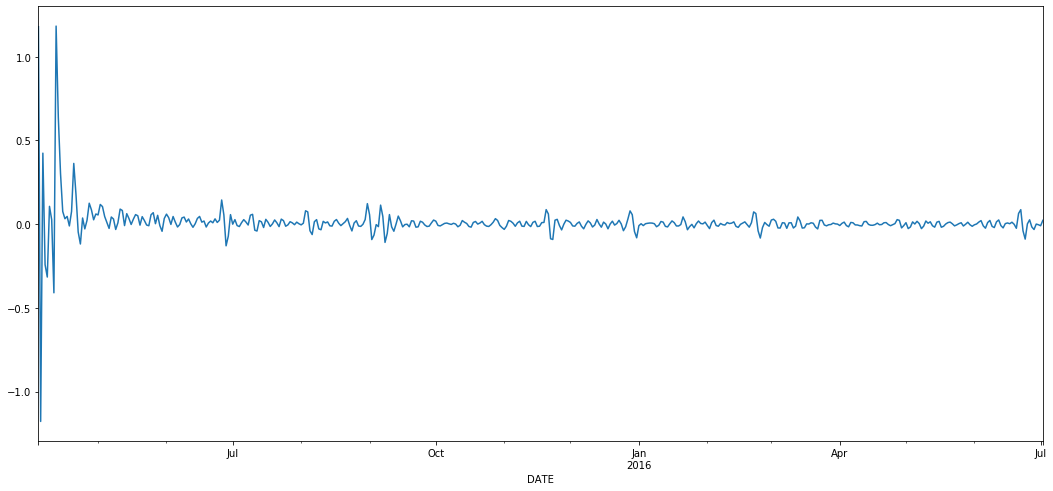

In [35]:
model = sm.tsa.statespace.SARIMAX(df_log_shift, order=(2,1,1), seasonal_order=(2,1,2,7)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()
res.plot() 

In [16]:
#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(7,8)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_log_shift,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.465617
         Iterations: 3
         Function evaluations: 148
SARIMA(0, 1, 1),(0, 1, 1, 7) - AIC:-1330.6428999875266


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.467516
         Iterations: 3
         Function evaluations: 201
SARIMA(0, 1, 1),(0, 1, 2, 7) - AIC:-1330.3743530437898


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.467533
         Iterations: 3
         Function evaluations: 179
SARIMA(0, 1, 1),(1, 1, 1, 7) - AIC:-1330.3898748608226


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.467848
         Iterations: 4
         Function evaluations: 280
SARIMA(0, 1, 1),(1, 1, 2, 7) - AIC:-1328.677759254953


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.468525
         Iterations: 4
         Function evaluations: 270
SARIMA(0, 1, 1),(2, 1, 1, 7) - AIC:-1329.2945453406633


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.470876
         Iterations: 6
         Function evaluations: 641
SARIMA(0, 1, 1),(2, 1, 2, 7) - AIC:-1329.4386260459196


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.598535
         Iterations: 3
         Function evaluations: 179
SARIMA(0, 1, 2),(0, 1, 1, 7) - AIC:-1449.8635757531097


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.600638
         Iterations: 5
         Function evaluations: 356
SARIMA(0, 1, 2),(0, 1, 2, 7) - AIC:-1449.7822967357251


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.599356
         Iterations: 4
         Function evaluations: 292
SARIMA(0, 1, 2),(1, 1, 1, 7) - AIC:-1448.6123458487295


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.600898
         Iterations: 4
         Function evaluations: 324
SARIMA(0, 1, 2),(1, 1, 2, 7) - AIC:-1448.0190108649117


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.609038
         Iterations: 5
         Function evaluations: 416
SARIMA(0, 1, 2),(2, 1, 1, 7) - AIC:-1455.4430781712026


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.610749
         Iterations: 8
         Function evaluations: 812
SARIMA(0, 1, 2),(2, 1, 2, 7) - AIC:-1455.0027585710109


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.653969
         Iterations: 3
         Function evaluations: 189
SARIMA(1, 1, 1),(0, 1, 1, 7) - AIC:-1500.4200212027047


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.656180
         Iterations: 3
         Function evaluations: 261
SARIMA(1, 1, 1),(0, 1, 2, 7) - AIC:-1500.4366140475995


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.655286
         Iterations: 4
         Function evaluations: 347
SARIMA(1, 1, 1),(1, 1, 1, 7) - AIC:-1499.6207202823477


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.656387
         Iterations: 3
         Function evaluations: 267
SARIMA(1, 1, 1),(1, 1, 2, 7) - AIC:-1498.6253948984627


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.663142
         Iterations: 4
         Function evaluations: 392
SARIMA(1, 1, 1),(2, 1, 1, 7) - AIC:-1504.7854308907395


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.665987
         Iterations: 6
         Function evaluations: 634
SARIMA(1, 1, 1),(2, 1, 2, 7) - AIC:-1505.380510499907


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.678176
         Iterations: 3
         Function evaluations: 214
SARIMA(1, 1, 2),(0, 1, 1, 7) - AIC:-1520.4963999889412


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.672807
         Iterations: 3
         Function evaluations: 287
SARIMA(1, 1, 2),(0, 1, 2, 7) - AIC:-1513.5998955011237


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.678509
         Iterations: 4
         Function evaluations: 363
SARIMA(1, 1, 2),(1, 1, 1, 7) - AIC:-1518.8004073416646


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.672656
         Iterations: 3
         Function evaluations: 325
SARIMA(1, 1, 2),(1, 1, 2, 7) - AIC:-1511.4619519483226


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.685765
         Iterations: 4
         Function evaluations: 394
SARIMA(1, 1, 2),(2, 1, 1, 7) - AIC:-1523.4173204298836


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.686861
         Iterations: 8
         Function evaluations: 913
SARIMA(1, 1, 2),(2, 1, 2, 7) - AIC:-1522.4168013025924


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.688104
         Iterations: 5
         Function evaluations: 407
SARIMA(2, 1, 1),(0, 1, 1, 7) - AIC:-1529.5504453013425


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.692696
         Iterations: 8
         Function evaluations: 880
SARIMA(2, 1, 1),(0, 1, 2, 7) - AIC:-1531.739128224644


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.692535
         Iterations: 4
         Function evaluations: 356
SARIMA(2, 1, 1),(1, 1, 1, 7) - AIC:-1531.5919126564352


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.693359
         Iterations: 8
         Function evaluations: 900
SARIMA(2, 1, 1),(1, 1, 2, 7) - AIC:-1530.34345756287


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.701789
         Iterations: 7
         Function evaluations: 772
SARIMA(2, 1, 1),(2, 1, 1, 7) - AIC:-1538.031530878793


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.704451
         Iterations: 9
         Function evaluations: 1065
SARIMA(2, 1, 1),(2, 1, 2, 7) - AIC:-1538.459353042691


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.653949
         Iterations: 3
         Function evaluations: 528
SARIMA(2, 1, 2),(0, 1, 1, 7) - AIC:-1496.4016827535615


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.674984
         Iterations: 4
         Function evaluations: 451
SARIMA(2, 1, 2),(0, 1, 2, 7) - AIC:-1513.5850994557968


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.674932
         Iterations: 4
         Function evaluations: 387
SARIMA(2, 1, 2),(1, 1, 1, 7) - AIC:-1513.5377803563827


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.674889
         Iterations: 4
         Function evaluations: 505
SARIMA(2, 1, 2),(1, 1, 2, 7) - AIC:-1511.4990035124124


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.510472
         Iterations: 2
         Function evaluations: 247
SARIMA(2, 1, 2),(2, 1, 1, 7) - AIC:-1361.5500875160287


/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.675682
         Iterations: 4
         Function evaluations: 530
SARIMA(2, 1, 2),(2, 1, 2, 7) - AIC:-1510.2219709998876


In [ ]:
!pip install pmdarima

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(act.ACTIVITY[:457], 
#            exog=train_X,
              order=(2,1,1), seasonal_order = (2,1,2,7),
              enforce_invertibility=False, enforce_stationarity=False)

/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [41]:
results= model.fit()

/Users/sankalpthakur/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [46]:
yhat= results.forecast(steps = 91)

In [48]:
yhat

2016-07-03    18971.396185
2016-07-04    22079.092506
2016-07-05    22371.948281
2016-07-06    19108.019854
2016-07-07    15673.401561
                  ...     
2016-09-27    22295.580060
2016-09-28    19053.883475
2016-09-29    15640.957160
2016-09-30    14338.967610
2016-10-01    15689.582790
Freq: D, Length: 91, dtype: float64

In [52]:
yhat.to_csv('actf.csv')